(activity20_solution)=

# Activity 20 Solution: Data wrangling with ecological data

**2025-11-24**

---

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Part 1: Understanding the raw data

We have messy table, `landplot_raw`, which corresponds to land-plot-level data:

- `plot_id`: unique identifier for each plot
- `ecosystem_type`: type of ecosystem (e.g., grassland, shrubland, forest)
- `trt_fertilizer_group`: treatment group
- `biomass_2023`: above-ground biomass in 2023 (g/m^2)
- `biomass_2024`: above-ground biomass in 2024 (g/m^2)
- `soil_nitrogen_pct`: soil nitrogen content prior to fertilization

Lets first inspect the structure of the dataframe:

In [6]:
landplots_raw = pd.read_csv("~/COMSC-341CD/data/plots_raw.csv")

landplots_raw.dtypes

# TODO inspect the rows, columns, and data types

plot_id                   int64
site_id                  object
ecosystem_type           object
biomass_2023            float64
biomass_2024            float64
trt_fertilizer_group     object
soil_nitrogen_pct       float64
dtype: object

## Units and IDs

For causal analysis, we need to be clear about what counts as a **unit** and how it is identified. We'll use `plot_id` to check for uniqueness and duplicates. Let's answer the following questions:

1. How many duplicated rows are there in `plots_raw`? 

2. Which `plot_ids`, if any, are duplicated?

In [15]:
# TODO print the number of duplicated rows
print(landplots_raw.shape[0] - landplots_raw['plot_id'].nunique())

# TODO print the duplicated plot_ids
print(landplots_raw[landplots_raw.duplicated(subset=['plot_id'])]['plot_id'])

landplots_raw[landplots_raw['plot_id'] == 501]

5
250    501
251    532
252    619
253    604
254    688
Name: plot_id, dtype: int64


plot_id site_id ecosystem_type  biomass_2023  biomass_2024  \
1        501      S1         forest         346.1         349.1   
250      501      S1         forest         346.1         349.1   

    trt_fertilizer_group  soil_nitrogen_pct  
1                   fert              0.452  
250                 fert              0.452

Then, we can drop the duplicates. Instead of overwriting `landplots_raw`, we'll create a new variable `landplots_clean` to preserve the original data.

In [17]:
landplots_clean = landplots_raw.copy()

# TODO drop duplicates from landplots_clean
landplots_clean = landplots_clean.drop_duplicates(subset=['plot_id'])

landplots_clean.shape[0] - landplots_clean['plot_id'].nunique()

#landplots_clean[landplots_clean['plot_id'] == 501]

0

# Part 2: Cleaning variables and columns

Next, we will clean key variables in `plots_raw`:

1. standardize `ecosystem_type` labels
2. rename `trt_fertilizer_group` to `treatment_group`
3. standardize `treatment_group` labels in a new column `treatment_group_clean`
4. create a binary indicator in a new column `treated`

In [21]:
# TODO standardize ecosystem_type labels
landplots_clean['ecosystem_type'] = landplots_clean['ecosystem_type'].str.lower().str.strip()
print(landplots_clean['ecosystem_type'].unique())

# TODO rename trt_fertilizer_group to treatment_group
landplots_clean = landplots_clean.rename(
    columns={'trt_fertilizer_group': 'treat_group'}
)

['forest' 'grassland']


In [22]:
landplots_clean.columns

Index(['plot_id', 'site_id', 'ecosystem_type', 'biomass_2023', 'biomass_2024',
       'treat_group', 'soil_nitrogen_pct'],
      dtype='object')

In [30]:
# TODO standardize treatment_group labels in a new column treatment_group_clean
print(landplots_clean['treat_group'].unique())

landplots_clean['treat_group_clean'] = landplots_clean['treat_group'].replace(
    {'T': 'fert',
     'C': 'control'}
)

print(landplots_clean['treat_group_clean'].unique())

# TODO treated binary treatment indicator: 1 if nitrogen fertilized, 0 if control
landplots_clean['treated'] = np.where(landplots_clean['treat_group_clean'] == 'fert', 1, 0)

['fert' 'C' 'T' 'control']
['fert' 'control']


In [31]:
landplots_clean.head()

plot_id site_id ecosystem_type  biomass_2023  biomass_2024 treat_group  \
0      500      S4         forest         245.5         185.5        fert   
1      501      S1         forest         346.1         349.1        fert   
2      502      S1      grassland         604.1         659.3           C   
3      503      S1         forest         452.0         431.5           T   
4      504      S2         forest         329.5         402.2        fert   

   soil_nitrogen_pct treat_group_clean  treated  
0              0.300              fert        1  
1              0.452              fert        1  
2              0.486           control        0  
3              0.417              fert        1  
4              0.515              fert        1

In [29]:
print(np.where(landplots_clean['treat_group_clean'] == 'fert', 1, 0)[:5])
landplots_clean.head()
#help(np.where)

[1 1 0 1 1]


plot_id site_id ecosystem_type  biomass_2023  biomass_2024 treat_group  \
0      500      S4         forest         245.5         185.5        fert   
1      501      S1         forest         346.1         349.1        fert   
2      502      S1      grassland         604.1         659.3           C   
3      503      S1         forest         452.0         431.5           T   
4      504      S2         forest         329.5         402.2        fert   

   soil_nitrogen_pct treat_group_clean  
0              0.300              fert  
1              0.452              fert  
2              0.486           control  
3              0.417              fert  
4              0.515              fert

# Part 3: Missingness and bad values

The biomass variables contain special codes and implausible values.

We'll first recode -99 as NaN in `biomass_2023` and `biomass_2024`:

In [34]:
# TODO replace -99 with NaN in `biomass_2023` and `biomass_2024`
print(landplots_clean['biomass_2023'].value_counts())

landplots_clean['biomass_2023'] = landplots_clean['biomass_2023'].replace({
    -99: np.nan,
    -50: np.nan
})

print(landplots_clean['biomass_2023'].value_counts())

biomass_2023
-99.0     5
-50.0     5
 449.6    2
 349.7    2
 480.0    2
         ..
 356.2    1
 346.0    1
 277.8    1
 359.7    1
 367.4    1
Name: count, Length: 232, dtype: int64
biomass_2023
498.0    2
428.9    2
349.7    2
451.4    2
367.9    2
        ..
356.2    1
346.0    1
277.8    1
359.7    1
367.4    1
Name: count, Length: 230, dtype: int64


Additionally, there are some implausible (negative) values in `biomass_2023`. We'll flag these with an indicator 
`biomass_2023_implausible`, and also set those values in `biomass_2023` to NaN:

In [ ]:
# TODO flag implausible biomass values with an indicator

# TODO set implausible biomass values in `biomass_2023` column to NaN


Next, we'll check the missingness rates of the variables. What percentage of values are missing in `biomass_2023` and `biomass_2024`?

In [38]:
# TODO check the missingness rates of the variables
landplots_clean['biomass_2023'].isna().mean()

np.float64(0.04)

# Part 4: Wide vs long data formats

Currently, our `landplots_clean` dataframe is violating the tidy data principle of "one row = one observation", due to the two biomass columns.

We can use [pd.melt()](https://pandas.pydata.org/docs/reference/api/pandas.melt.html) to convert the dataframe from wide to long format. This pandas function "unpivots" (or "melts") the dataframe, turning multiple columns into a single column of values, and the column names into a new column with our choice of name. Specifically, it takes the following arguments:

- `id_vars`: columns to keep as identifier variables
- `value_vars`: columns to unpivot
- `var_name`: name of the new `variable` column
- `value_name`: name of the new `value` column

In [44]:
display(landplots_clean.head())

# TODO melt the dataframe from wide to long format
landplots_long = pd.melt(landplots_clean,
                         id_vars=["plot_id", "treated","ecosystem_type"],
                         value_vars=["biomass_2023", "biomass_2024"],
                         var_name="year",
                         value_name="biomass")


# TODO clean the year column to be numeric (e.g., 2023, 2024)
landplots_long["year"] = landplots_long["year"].apply(lambda x: x.split("_")[1]).astype(int)

display(landplots_long)
print(landplots_long.shape)

plot_id site_id ecosystem_type  biomass_2023  biomass_2024 treat_group  \
0      500      S4         forest         245.5         185.5        fert   
1      501      S1         forest         346.1         349.1        fert   
2      502      S1      grassland         604.1         659.3           C   
3      503      S1         forest         452.0         431.5           T   
4      504      S2         forest         329.5         402.2        fert   

   soil_nitrogen_pct treat_group_clean  treated  
0              0.300              fert        1  
1              0.452              fert        1  
2              0.486           control        0  
3              0.417              fert        1  
4              0.515              fert        1

plot_id  treated ecosystem_type  year  biomass
0        500        1         forest  2023    245.5
1        501        1         forest  2023    346.1
2        502        0      grassland  2023    604.1
3        503        1         forest  2023    452.0
4        504        1         forest  2023    329.5
..       ...      ...            ...   ...      ...
495      745        1      grassland  2024    467.9
496      746        0      grassland  2024    519.7
497      747        1      grassland  2024    335.3
498      748        0      grassland  2024    449.1
499      749        1      grassland  2024    430.9

[500 rows x 5 columns]

(500, 5)


Now that our data is in long format, we can visualize the average biomass over the two timepoints by treatment group using a sns.lineplot() with:

- `x = year`
- `y = biomass`
- `hue = treated`

<Axes: xlabel='year', ylabel='biomass'>

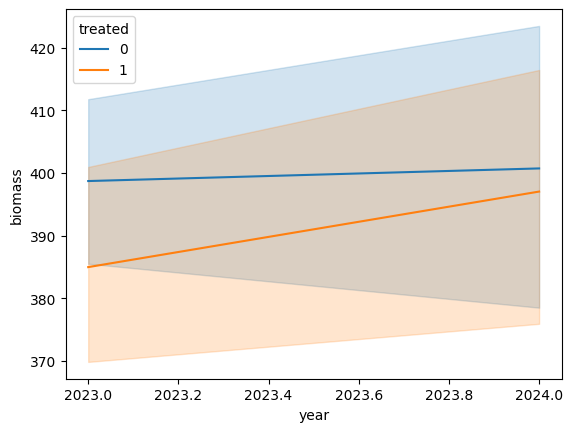

In [45]:
# TODO plot a line plot of biomass over time by treatment group
sns.lineplot(x='year', y='biomass', hue='treated', data=landplots_long)

Finally, if we'd like to return to the wide format, we can use [pd.pivot()](https://pandas.pydata.org/docs/reference/api/pandas.pivot.html) to pivot the dataframe from long to wide format. This function takes the following arguments:

- `index`: column(s) to use as the index (rows)
- `columns`: variable to use as the columns: one new column for each unique value
- `values`: column to use as the values to fill the new dataframe cells


In [46]:
# TODO pivot the dataframe from long to wide format
# index = plot_id
# columns = year
# values = biomass

landplots_wide = landplots_long.pivot(
    index="plot_id",
    columns="year",
    values="biomass"
)

landplots_wide

year      2023   2024
plot_id              
500      245.5  185.5
501      346.1  349.1
502      604.1  659.3
503      452.0  431.5
504      329.5  402.2
...        ...    ...
745      447.4  467.9
746      416.6  519.7
747      342.1  335.3
748      472.7  449.1
749      367.4  430.9

[250 rows x 2 columns]